# **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Unpacking .rar files**

In [ ]:
!pip install pyunpack
!pip install patool

In [ ]:
src = "/content/drive/MyDrive/Sharp_input2.rar"
dst = "/content/drive/MyDrive/Sharp_input2"

from pyunpack import Archive
Archive(src).extractall(dst)

In [ ]:
%rm -rf /content/drive/MyDrive/Laplacian_input2

# **Libraries**

In [ ]:
pip install segmentation-models-3D

In [ ]:
import os
import sys
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

import keras
import random
import segmentation_models_3D as sm

import cv2
import math
import pandas as pd
import skimage
from skimage import io
from tensorflow.keras.models import load_model
from keras import backend as K

Segmentation Models: using `tf.keras` framework.


# **Auto Feature Extraction**

####Saving images as Numpy Arrays

In [ ]:
scaler = MinMaxScaler()

t2_list = sorted(glob.glob('/content/drive/MyDrive/BraTS2020/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/BraTS2020/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/BraTS2020/*/*flair.nii'))

for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/input1/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/input1/masks/mask_'+str(img)+'.npy', temp_mask)

### Working on Numpy Images

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)



def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)  

            batch_start += batch_size   
            batch_end += batch_size

# Simple U-Net Model

In [ ]:
kernel_initializer =  'he_uniform'

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs
    
    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

Loading Images

In [ ]:
train_img_dir = '/content/drive/MyDrive/input2/train/images/'
train_mask_dir = '/content/drive/MyDrive/input2/train/masks/'

val_img_dir = '/content/drive/MyDrive/input2/val/images/'
val_mask_dir = '/content/drive/MyDrive/input2/val/masks/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

Displaying Random Slices of original Images

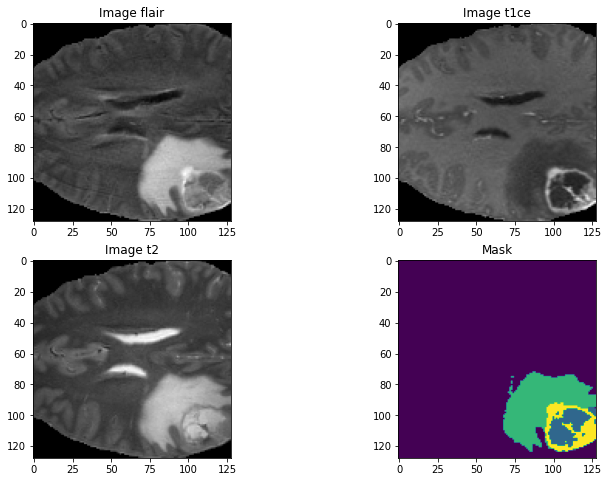

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

### Training the Model

In [ ]:
history=model.fit(
        train_img_datagen,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        verbose=1,
        validation_data=val_img_datagen,
        validation_steps=val_steps_per_epoch,
        )

model.save('/content/drive/MyDrive/MODELS/20_epochs_model.hdf5')

## Resuming the training

### 20-40 Epochs

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/20_epochs_model.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

my_model.save('/content/drive/MyDrive/MODELS/40_epochs_model.hdf5')

Epoch 1/20
64/64 [==============================] - 387s 6s/step - loss: 0.8742 - accuracy: 0.9561 - iou_score: 0.4547 - val_loss: 0.8785 - val_accuracy: 0.9330 - val_iou_score: 0.4542
Epoch 2/20
64/64 [==============================] - 401s 6s/step - loss: 0.8722 - accuracy: 0.9570 - iou_score: 0.4613 - val_loss: 0.8860 - val_accuracy: 0.9199 - val_iou_score: 0.4335
Epoch 3/20
64/64 [==============================] - 401s 6s/step - loss: 0.8670 - accuracy: 0.9612 - iou_score: 0.4791 - val_loss: 0.8690 - val_accuracy: 0.9530 - val_iou_score: 0.4719
Epoch 4/20
64/64 [==============================] - 450s 7s/step - loss: 0.8618 - accuracy: 0.9649 - iou_score: 0.4928 - val_loss: 0.8702 - val_accuracy: 0.9574 - val_iou_score: 0.4661
Epoch 5/20
64/64 [==============================] - 422s 7s/step - loss: 0.8613 - accuracy: 0.9643 - iou_score: 0.4939 - val_loss: 0.8689 - val_accuracy: 0.9498 - val_iou_score: 0.4754
Epoch 6/20
64/64 [==============================] - 416s 7s/step - loss: 0.

### 40-60 Epochs

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/40_epochs_model.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

my_model.save('/content/drive/MyDrive/MODELS/60_epochs_model.hdf5')

Epoch 1/20
64/64 [==============================] - 465s 7s/step - loss: 0.8374 - accuracy: 0.9680 - iou_score: 0.5772 - val_loss: 0.8440 - val_accuracy: 0.9721 - val_iou_score: 0.5542
Epoch 2/20
64/64 [==============================] - 457s 7s/step - loss: 0.8356 - accuracy: 0.9699 - iou_score: 0.5841 - val_loss: 0.8464 - val_accuracy: 0.9719 - val_iou_score: 0.5445
Epoch 3/20
64/64 [==============================] - 470s 7s/step - loss: 0.8349 - accuracy: 0.9702 - iou_score: 0.5864 - val_loss: 0.8453 - val_accuracy: 0.9721 - val_iou_score: 0.5465
Epoch 4/20
64/64 [==============================] - 452s 7s/step - loss: 0.8333 - accuracy: 0.9707 - iou_score: 0.5922 - val_loss: 0.8437 - val_accuracy: 0.9728 - val_iou_score: 0.5527
Epoch 5/20
64/64 [==============================] - 402s 6s/step - loss: 0.8340 - accuracy: 0.9706 - iou_score: 0.5898 - val_loss: 0.8491 - val_accuracy: 0.9717 - val_iou_score: 0.5337
Epoch 6/20
64/64 [==============================] - 399s 6s/step - loss: 0.

### 60-80 Epochs

In [ ]:
# Now, let us add the iou_score function we used during our initial training
my_model = load_model('/content/drive/MyDrive/MODELS/60_epochs_model.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

my_model.save('/content/drive/MyDrive/MODELS/80_epochs_model.hdf5')

Epoch 1/20
64/64 [==============================] - 411s 6s/step - loss: 0.8233 - accuracy: 0.9754 - iou_score: 0.6298 - val_loss: 0.8270 - val_accuracy: 0.9765 - val_iou_score: 0.6181
Epoch 2/20
64/64 [==============================] - 417s 7s/step - loss: 0.8227 - accuracy: 0.9751 - iou_score: 0.6321 - val_loss: 0.8265 - val_accuracy: 0.9766 - val_iou_score: 0.6205
Epoch 3/20
64/64 [==============================] - 423s 7s/step - loss: 0.8227 - accuracy: 0.9750 - iou_score: 0.6320 - val_loss: 0.8267 - val_accuracy: 0.9765 - val_iou_score: 0.6198
Epoch 4/20
64/64 [==============================] - 450s 7s/step - loss: 0.8217 - accuracy: 0.9754 - iou_score: 0.6353 - val_loss: 0.8253 - val_accuracy: 0.9765 - val_iou_score: 0.6243
Epoch 5/20
64/64 [==============================] - 404s 6s/step - loss: 0.8221 - accuracy: 0.9756 - iou_score: 0.6338 - val_loss: 0.8258 - val_accuracy: 0.9761 - val_iou_score: 0.6225
Epoch 6/20
64/64 [==============================] - 446s 7s/step - loss: 0.

### Making some predictions

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/80_epochs_model.hdf5', compile=False)

batch_size=8 
test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.675133


In [ ]:
def Prediction(img_num):
    test_img = np.load("/content/drive/MyDrive/input2/val/images/image_"+str(img_num)+".npy")

    test_mask = np.load("/content/drive/MyDrive/input2/val/masks/mask_"+str(img_num)+".npy")
    test_mask_argmax=np.argmax(test_mask, axis=3)

    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = my_model.predict(test_img_input)
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

    n_slice = 55
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:, n_slice])
    plt.show()

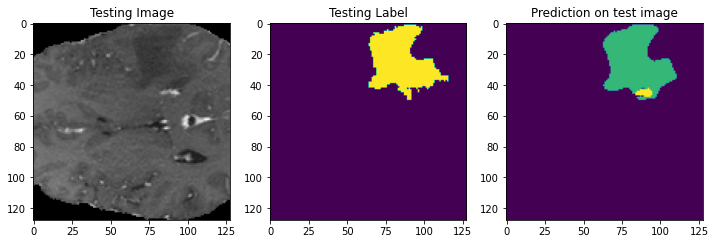

In [ ]:
Prediction(15)

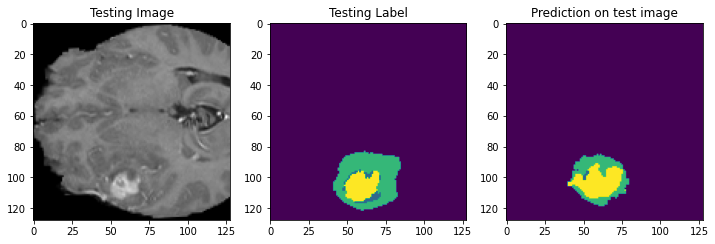

In [ ]:
Prediction(132)

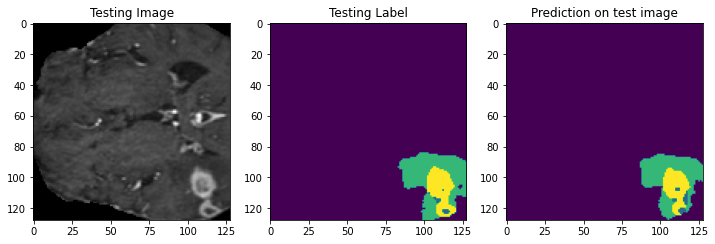

In [ ]:
Prediction(126)

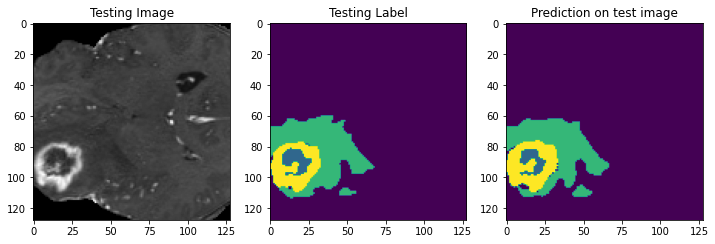

In [ ]:
Prediction(120)

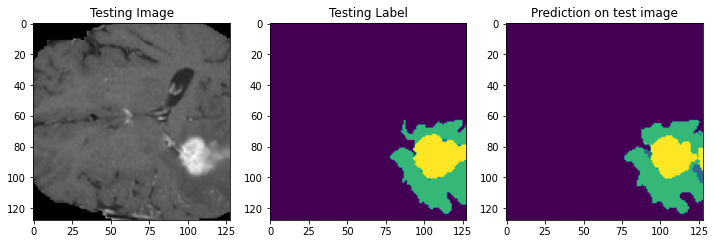

In [ ]:
Prediction(200)

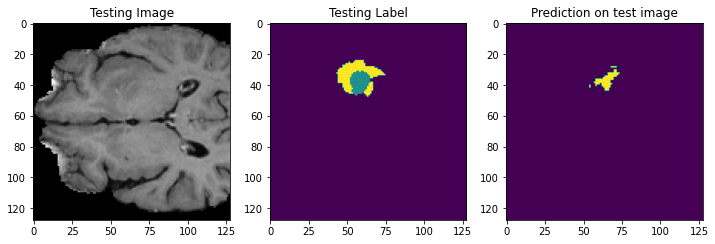

In [ ]:
Prediction(303)

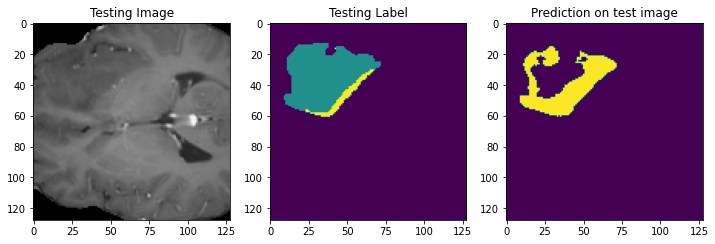

In [ ]:
Prediction(323)

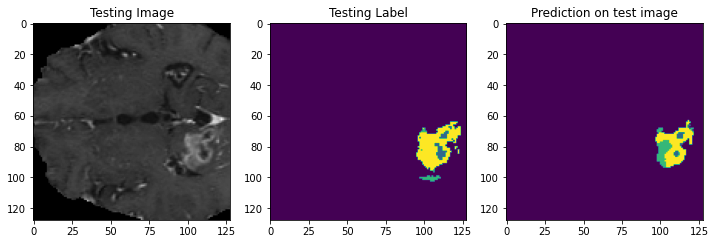

In [ ]:
Prediction(41)

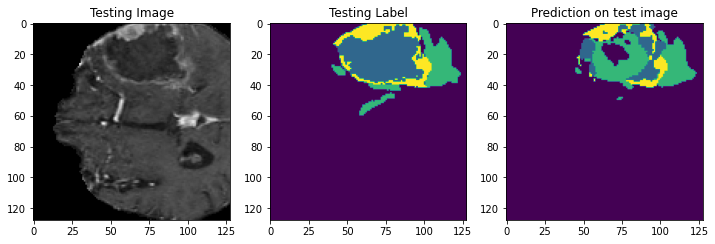

In [ ]:
Prediction(99)

# **Hybrid Model with Manual Features**

### Creating the new Model

In [ ]:
kernel_initializer =  'he_uniform'

def new_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    input1 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    input2 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    A = input1
    B = input2
    
    #Contraction path
    c1A = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(A)
    c1A = Dropout(0.1)(c1A)
    c1A = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1A)
    p1A = MaxPooling3D((1, 1, 1))(c1A)
    
    p1 = concatenate([p1A, B])

    # input 128
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    # input 64
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    
    # input 32
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    # input 16
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    # Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (1, 1, 1), strides=(1, 1, 1), padding='same')(c8)
    u9 = concatenate([u9, c1A])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(u9)
     
    model = Model(inputs=[input1, input2], outputs=[outputs])
    
    return model

### Utility Functions

In [ ]:
def continueTraining(src, dst):
    new_model = load_model(src, custom_objects={'dice_loss_plus_1focal_loss': total_loss, 'iou_score':sm.metrics.IOUScore(threshold=0.5)})

    history2=new_model.fit(train_img_datagen,
            steps_per_epoch=steps_per_epoch,
            epochs=5,
            verbose=1,
            validation_data=val_img_datagen,
            validation_steps=val_steps_per_epoch,
            )

    new_model.save(dst)

In [ ]:
import random

def Prediction(img_num, test_img_path, test_feature_path, test_mask_path):

    test_img = np.load(test_img_path+str(img_num)+".npy")
    test_feature = np.load(test_feature_path+str(img_num)+".npy")
    test_mask = np.load(test_mask_path+str(img_num)+".npy")
    test_mask_argmax = np.argmax(test_mask, axis=3)

    test_img_input = np.expand_dims(test_img, axis=0)
    test_feature_input = np.expand_dims(test_feature, axis=0)
    x = [test_img_input, test_feature_input]            # getting two inputs to pass to the model for prediction...
    test_prediction = my_model.predict(x)
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

    n_slice = 55
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:, n_slice])
    plt.show()

In [ ]:
def imageLoader2(img_dir, img_list, feature_dir, feature_list, mask_dir, mask_list, fmask_dir, fmask_list, batch_size):

    L = len(img_list)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                    
            A = load_img(img_dir, img_list[batch_start:limit])
            B = load_img(mask_dir, mask_list[batch_start:limit])
            C = load_img(feature_dir, feature_list[batch_start:limit])

            yield ([A,C],B)
            
            batch_start += batch_size   
            batch_end += batch_size

### Compilation of the Model

In [ ]:
train_img_dir = '/content/drive/MyDrive/input2/train/images/'
train_mask_dir = '/content/drive/MyDrive/input2/train/masks/'

val_img_dir = '/content/drive/MyDrive/input2/val/images/'
val_mask_dir = '/content/drive/MyDrive/input2/val/masks/'

# train_feature_dir = '/content/drive/MyDrive/Laplacian_input2/Laplacian_input2/train/images/'
# val_feature_dir = '/content/drive/MyDrive/Laplacian_input2/Laplacian_input2/val/images/'

# train_feature_dir = '/content/drive/MyDrive/Meijering_input2/Meijering_input2/train/images/'
# val_feature_dir = '/content/drive/MyDrive/Meijering_input2/Meijering_input2/val/images/'

train_feature_dir = '/content/drive/MyDrive/Sharp_input2/Sharp_input2/train/images/'
val_feature_dir = '/content/drive/MyDrive/Sharp_input2/Sharp_input2/val/images/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

train_feature_list = os.listdir(train_feature_dir)
val_feature_list = os.listdir(val_feature_dir)

batch_size = 2

train_img_datagen = imageLoader2(train_img_dir, train_img_list, train_feature_dir, train_feature_list, 
                                    train_mask_dir, train_mask_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader2(val_img_dir, val_img_list, val_feature_dir, val_feature_list, val_mask_dir, 
                                    val_mask_list, val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img[0].shape[0]-1)
test_img=img[0][img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

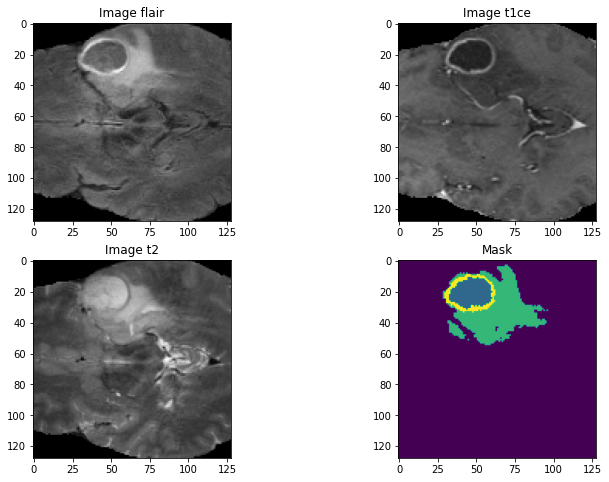

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

new_model = new_unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)

new_model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

# Training Models with Features

## 1. With Laplacian Features

### Training First 20 Epochs

In [ ]:
history=new_model.fit(
        train_img_datagen,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        verbose=1,
        validation_data=val_img_datagen,
        validation_steps=val_steps_per_epoch,
        )

new_model.save('/content/drive/MyDrive/MODELS/20_epochs_hybrid_model(1).hdf5')

Epoch 1/20
129/129 [==============================] - 675s 5s/step - loss: 0.9562 - accuracy: 0.8851 - iou_score: 0.1936 - val_loss: 0.9312 - val_accuracy: 0.9149 - val_iou_score: 0.2478
Epoch 2/20
129/129 [==============================] - 663s 5s/step - loss: 0.9249 - accuracy: 0.9445 - iou_score: 0.2862 - val_loss: 0.9248 - val_accuracy: 0.9222 - val_iou_score: 0.2740
Epoch 3/20
129/129 [==============================] - 647s 5s/step - loss: 0.9186 - accuracy: 0.9405 - iou_score: 0.2931 - val_loss: 0.9123 - val_accuracy: 0.9476 - val_iou_score: 0.3003
Epoch 4/20
129/129 [==============================] - 625s 5s/step - loss: 0.9129 - accuracy: 0.9321 - iou_score: 0.3287 - val_loss: 0.9070 - val_accuracy: 0.9415 - val_iou_score: 0.3536
Epoch 5/20
129/129 [==============================] - 628s 5s/step - loss: 0.9054 - accuracy: 0.9374 - iou_score: 0.3671 - val_loss: 0.9009 - val_accuracy: 0.9392 - val_iou_score: 0.3748
Epoch 6/20
129/129 [==============================] - 585s 5s/ste

### 20-40 Epochs

In [ ]:
new_model = load_model('/content/drive/MyDrive/MODELS/20_epochs_hybrid_model(1).hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

history2=new_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

new_model.save('/content/drive/MyDrive/MODELS/40_epochs_hybrid_model(1).hdf5')

Epoch 1/20
129/129 [==============================] - 585s 5s/step - loss: 0.8458 - accuracy: 0.9733 - iou_score: 0.5452 - val_loss: 0.8619 - val_accuracy: 0.9669 - val_iou_score: 0.4900
Epoch 2/20
129/129 [==============================] - 573s 4s/step - loss: 0.8425 - accuracy: 0.9736 - iou_score: 0.5570 - val_loss: 0.8567 - val_accuracy: 0.9699 - val_iou_score: 0.5074
Epoch 3/20
129/129 [==============================] - 561s 4s/step - loss: 0.8387 - accuracy: 0.9748 - iou_score: 0.5709 - val_loss: 0.8551 - val_accuracy: 0.9697 - val_iou_score: 0.5138
Epoch 4/20
129/129 [==============================] - 564s 4s/step - loss: 0.8369 - accuracy: 0.9755 - iou_score: 0.5776 - val_loss: 0.8611 - val_accuracy: 0.9655 - val_iou_score: 0.4961
Epoch 5/20
129/129 [==============================] - 556s 4s/step - loss: 0.8359 - accuracy: 0.9755 - iou_score: 0.5816 - val_loss: 0.8536 - val_accuracy: 0.9697 - val_iou_score: 0.5182
Epoch 6/20
129/129 [==============================] - 558s 4s/ste

### 40-60 Epochs

In [ ]:
new_model = load_model('/content/drive/MyDrive/MODELS/40_epochs_hybrid_model(1).hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

history2=new_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

new_model.save('/content/drive/MyDrive/MODELS/60_epochs_hybrid_model(1).hdf5')

Epoch 1/20
129/129 [==============================] - 575s 4s/step - loss: 0.8118 - accuracy: 0.9817 - iou_score: 0.6743 - val_loss: 0.8334 - val_accuracy: 0.9762 - val_iou_score: 0.5966
Epoch 2/20
129/129 [==============================] - 559s 4s/step - loss: 0.8105 - accuracy: 0.9826 - iou_score: 0.6787 - val_loss: 0.8292 - val_accuracy: 0.9770 - val_iou_score: 0.6112
Epoch 3/20
129/129 [==============================] - 572s 4s/step - loss: 0.8099 - accuracy: 0.9825 - iou_score: 0.6805 - val_loss: 0.8267 - val_accuracy: 0.9774 - val_iou_score: 0.6223
Epoch 4/20
129/129 [==============================] - 556s 4s/step - loss: 0.8088 - accuracy: 0.9831 - iou_score: 0.6853 - val_loss: 0.8294 - val_accuracy: 0.9766 - val_iou_score: 0.6119
Epoch 5/20
129/129 [==============================] - 556s 4s/step - loss: 0.8094 - accuracy: 0.9827 - iou_score: 0.6835 - val_loss: 0.8253 - val_accuracy: 0.9783 - val_iou_score: 0.6285
Epoch 6/20
129/129 [==============================] - 559s 4s/ste

### 60-80 Epochs

In [ ]:
new_model = load_model('/content/drive/MyDrive/MODELS/60_epochs_hybrid_model(1).hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

history2=new_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

new_model.save('/content/drive/MyDrive/MODELS/80_epochs_hybrid_model(1).hdf5')

Epoch 1/20
129/129 [==============================] - 581s 4s/step - loss: 0.7962 - accuracy: 0.9867 - iou_score: 0.7400 - val_loss: 0.8216 - val_accuracy: 0.9798 - val_iou_score: 0.6435
Epoch 2/20
129/129 [==============================] - 571s 4s/step - loss: 0.7956 - accuracy: 0.9869 - iou_score: 0.7429 - val_loss: 0.8228 - val_accuracy: 0.9798 - val_iou_score: 0.6363
Epoch 3/20
129/129 [==============================] - 558s 4s/step - loss: 0.7960 - accuracy: 0.9865 - iou_score: 0.7411 - val_loss: 0.8230 - val_accuracy: 0.9791 - val_iou_score: 0.6387
Epoch 4/20
129/129 [==============================] - 558s 4s/step - loss: 0.7953 - accuracy: 0.9870 - iou_score: 0.7439 - val_loss: 0.8271 - val_accuracy: 0.9768 - val_iou_score: 0.6228
Epoch 5/20
129/129 [==============================] - 552s 4s/step - loss: 0.7955 - accuracy: 0.9866 - iou_score: 0.7432 - val_loss: 0.8216 - val_accuracy: 0.9785 - val_iou_score: 0.6454
Epoch 6/20
129/129 [==============================] - 550s 4s/ste

### Making some Predictions

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/80_epochs_hybrid_model(1).hdf5', compile=False)

# Verify IoU on a batch of images from the test dataset
from tensorflow.keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
# test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

test_img_datagen = imageLoader2(train_img_dir, train_img_list, train_feature_dir, train_feature_list, 
                                    train_mask_dir, train_mask_list, train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7731267


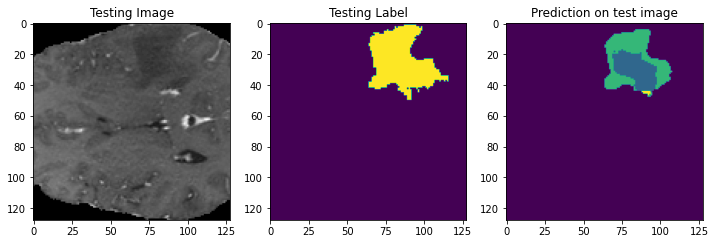

In [ ]:
# Calling the prediction Function...
test_img = "/content/drive/MyDrive/input2/val/images/image_"
test_feature = "/content/drive/MyDrive/Laplacian_input2/Laplacian_input2/val/images/image_"
test_mask = "/content/drive/MyDrive/input2/val/masks/mask_"

Prediction(15, test_img, test_feature, test_mask)

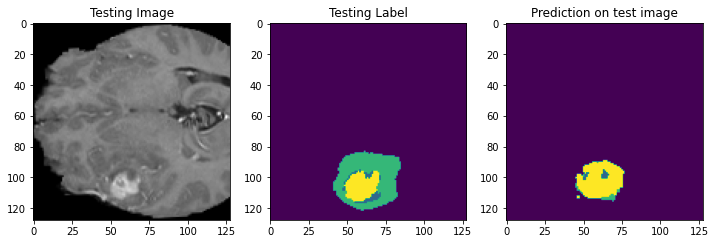

In [ ]:
Prediction(132, test_img, test_feature, test_mask)

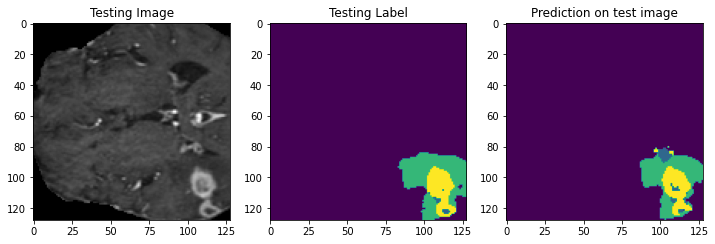

In [ ]:
Prediction(126, test_img, test_feature, test_mask)

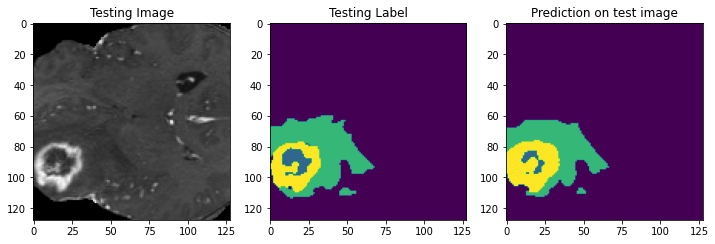

In [ ]:
Prediction(120, test_img, test_feature, test_mask)

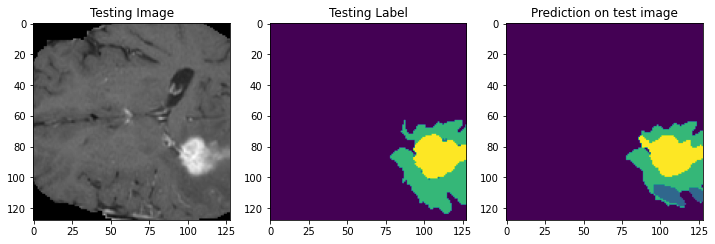

In [ ]:
Prediction(200, test_img, test_feature, test_mask)

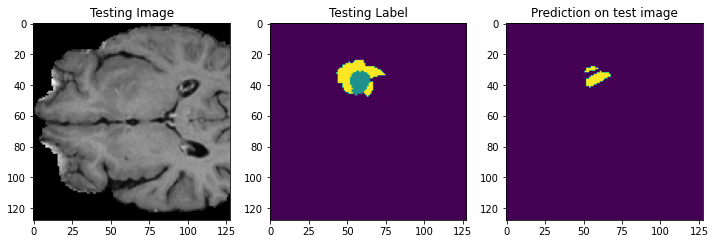

In [ ]:
Prediction(303, test_img, test_feature, test_mask)

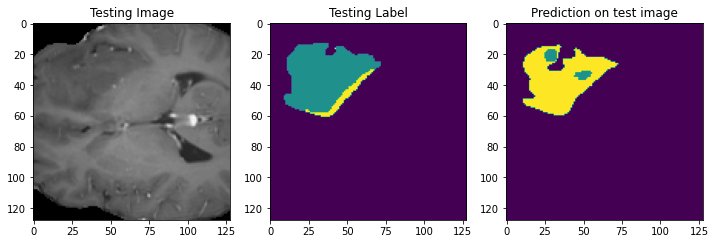

In [ ]:
Prediction(323, test_img, test_feature, test_mask)

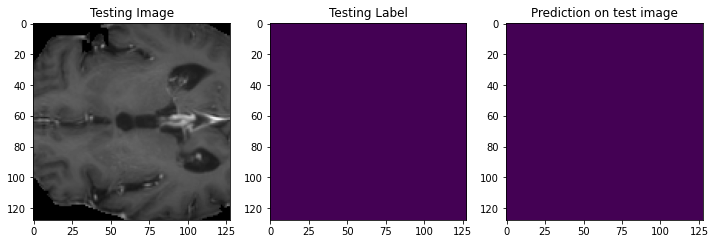

In [ ]:
Prediction(345, test_img, test_feature, test_mask)

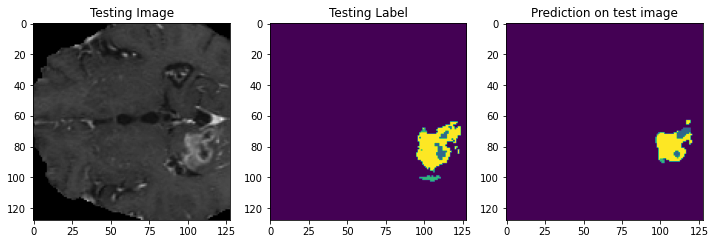

In [ ]:
Prediction(41, test_img, test_feature, test_mask)

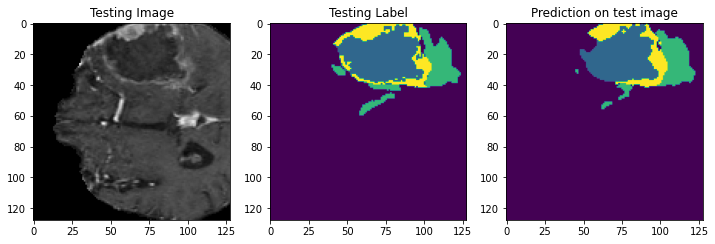

In [ ]:
Prediction(99, test_img, test_feature, test_mask)

## 2. With Meijering Features

### Training First 20 Epochs

In [ ]:
history=new_model.fit(
        train_img_datagen,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        verbose=1,
        validation_data=val_img_datagen,
        validation_steps=val_steps_per_epoch,
        )

new_model.save('/content/drive/MyDrive/MODELS/20_epochs_hybrid_model(2).hdf5')

Epoch 1/20
129/129 [==============================] - 765s 6s/step - loss: 0.9483 - accuracy: 0.9253 - iou_score: 0.2185 - val_loss: 0.9387 - val_accuracy: 0.9503 - val_iou_score: 0.2303
Epoch 2/20
129/129 [==============================] - 668s 5s/step - loss: 0.9317 - accuracy: 0.9492 - iou_score: 0.2488 - val_loss: 0.9187 - val_accuracy: 0.9537 - val_iou_score: 0.2940
Epoch 3/20
129/129 [==============================] - 635s 5s/step - loss: 0.9125 - accuracy: 0.9382 - iou_score: 0.3287 - val_loss: 0.9133 - val_accuracy: 0.9521 - val_iou_score: 0.3357
Epoch 4/20
129/129 [==============================] - 661s 5s/step - loss: 0.9047 - accuracy: 0.9379 - iou_score: 0.3699 - val_loss: 0.9030 - val_accuracy: 0.9549 - val_iou_score: 0.3685
Epoch 5/20
129/129 [==============================] - 614s 5s/step - loss: 0.8979 - accuracy: 0.9451 - iou_score: 0.3867 - val_loss: 0.9019 - val_accuracy: 0.9581 - val_iou_score: 0.3692
Epoch 6/20
129/129 [==============================] - 611s 5s/ste

### 20-40 Epochs

In [ ]:
src = '/content/drive/MyDrive/MODELS/20_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/25_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 653s 5s/step - loss: 0.8231 - accuracy: 0.9780 - iou_score: 0.6316 - val_loss: 0.8370 - val_accuracy: 0.9749 - val_iou_score: 0.5878
Epoch 2/5
129/129 [==============================] - 679s 5s/step - loss: 0.8192 - accuracy: 0.9789 - iou_score: 0.6463 - val_loss: 0.8329 - val_accuracy: 0.9759 - val_iou_score: 0.6050
Epoch 3/5
129/129 [==============================] - 585s 5s/step - loss: 0.8158 - accuracy: 0.9802 - iou_score: 0.6593 - val_loss: 0.8330 - val_accuracy: 0.9759 - val_iou_score: 0.6052
Epoch 4/5
129/129 [==============================] - 613s 5s/step - loss: 0.8158 - accuracy: 0.9805 - iou_score: 0.6596 - val_loss: 0.8325 - val_accuracy: 0.9764 - val_iou_score: 0.6051
Epoch 5/5
129/129 [==============================] - 601s 5s/step - loss: 0.8151 - accuracy: 0.9804 - iou_score: 0.6615 - val_loss: 0.8307 - val_accuracy: 0.9771 - val_iou_score: 0.6128


In [ ]:
src = '/content/drive/MyDrive/MODELS/25_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/30_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 701s 5s/step - loss: 0.8141 - accuracy: 0.9807 - iou_score: 0.6665 - val_loss: 0.8280 - val_accuracy: 0.9779 - val_iou_score: 0.6232
Epoch 2/5
129/129 [==============================] - 648s 5s/step - loss: 0.8115 - accuracy: 0.9815 - iou_score: 0.6767 - val_loss: 0.8314 - val_accuracy: 0.9774 - val_iou_score: 0.6124
Epoch 3/5
129/129 [==============================] - 658s 5s/step - loss: 0.8118 - accuracy: 0.9813 - iou_score: 0.6754 - val_loss: 0.8331 - val_accuracy: 0.9763 - val_iou_score: 0.6047
Epoch 4/5
129/129 [==============================] - 612s 5s/step - loss: 0.8095 - accuracy: 0.9819 - iou_score: 0.6849 - val_loss: 0.8306 - val_accuracy: 0.9776 - val_iou_score: 0.6164
Epoch 5/5
129/129 [==============================] - 616s 5s/step - loss: 0.8088 - accuracy: 0.9821 - iou_score: 0.6872 - val_loss: 0.8280 - val_accuracy: 0.9778 - val_iou_score: 0.6252


In [ ]:
src = '/content/drive/MyDrive/MODELS/30_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/35_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 644s 5s/step - loss: 0.8065 - accuracy: 0.9829 - iou_score: 0.6967 - val_loss: 0.8231 - val_accuracy: 0.9793 - val_iou_score: 0.6418
Epoch 2/5
129/129 [==============================] - 626s 5s/step - loss: 0.8064 - accuracy: 0.9831 - iou_score: 0.6971 - val_loss: 0.8270 - val_accuracy: 0.9785 - val_iou_score: 0.6309
Epoch 3/5
129/129 [==============================] - 636s 5s/step - loss: 0.8045 - accuracy: 0.9837 - iou_score: 0.7057 - val_loss: 0.8233 - val_accuracy: 0.9795 - val_iou_score: 0.6419
Epoch 4/5
129/129 [==============================] - 639s 5s/step - loss: 0.8060 - accuracy: 0.9834 - iou_score: 0.6990 - val_loss: 0.8246 - val_accuracy: 0.9792 - val_iou_score: 0.6357
Epoch 5/5
129/129 [==============================] - 619s 5s/step - loss: 0.8046 - accuracy: 0.9836 - iou_score: 0.7059 - val_loss: 0.8252 - val_accuracy: 0.9779 - val_iou_score: 0.6333


In [ ]:
src = '/content/drive/MyDrive/MODELS/35_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/40_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 661s 5s/step - loss: 0.8021 - accuracy: 0.9847 - iou_score: 0.7140 - val_loss: 0.8225 - val_accuracy: 0.9793 - val_iou_score: 0.6442
Epoch 2/5
129/129 [==============================] - 625s 5s/step - loss: 0.8009 - accuracy: 0.9850 - iou_score: 0.7198 - val_loss: 0.8256 - val_accuracy: 0.9784 - val_iou_score: 0.6331
Epoch 3/5
129/129 [==============================] - 626s 5s/step - loss: 0.7993 - accuracy: 0.9855 - iou_score: 0.7263 - val_loss: 0.8232 - val_accuracy: 0.9797 - val_iou_score: 0.6419
Epoch 4/5
129/129 [==============================] - 651s 5s/step - loss: 0.7987 - accuracy: 0.9858 - iou_score: 0.7295 - val_loss: 0.8230 - val_accuracy: 0.9791 - val_iou_score: 0.6428
Epoch 5/5
129/129 [==============================] - 629s 5s/step - loss: 0.7982 - accuracy: 0.9859 - iou_score: 0.7315 - val_loss: 0.8239 - val_accuracy: 0.9790 - val_iou_score: 0.6439


### 40-60 Epochs

In [ ]:
src = '/content/drive/MyDrive/MODELS/40_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/45_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 689s 5s/step - loss: 0.7982 - accuracy: 0.9860 - iou_score: 0.7318 - val_loss: 0.8223 - val_accuracy: 0.9796 - val_iou_score: 0.6468
Epoch 2/5
129/129 [==============================] - 644s 5s/step - loss: 0.7988 - accuracy: 0.9858 - iou_score: 0.7293 - val_loss: 0.8237 - val_accuracy: 0.9794 - val_iou_score: 0.6415
Epoch 3/5
129/129 [==============================] - 625s 5s/step - loss: 0.7964 - accuracy: 0.9866 - iou_score: 0.7395 - val_loss: 0.8219 - val_accuracy: 0.9793 - val_iou_score: 0.6491
Epoch 4/5
129/129 [==============================] - 665s 5s/step - loss: 0.7958 - accuracy: 0.9867 - iou_score: 0.7420 - val_loss: 0.8232 - val_accuracy: 0.9793 - val_iou_score: 0.6467
Epoch 5/5
129/129 [==============================] - 615s 5s/step - loss: 0.7954 - accuracy: 0.9868 - iou_score: 0.7442 - val_loss: 0.8210 - val_accuracy: 0.9805 - val_iou_score: 0.6521


In [ ]:
src = '/content/drive/MyDrive/MODELS/45_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/50_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 641s 5s/step - loss: 0.7937 - accuracy: 0.9874 - iou_score: 0.7511 - val_loss: 0.8212 - val_accuracy: 0.9799 - val_iou_score: 0.6483
Epoch 2/5
129/129 [==============================] - 702s 5s/step - loss: 0.7930 - accuracy: 0.9877 - iou_score: 0.7547 - val_loss: 0.8261 - val_accuracy: 0.9792 - val_iou_score: 0.6335
Epoch 3/5
129/129 [==============================] - 646s 5s/step - loss: 0.7939 - accuracy: 0.9872 - iou_score: 0.7510 - val_loss: 0.8244 - val_accuracy: 0.9780 - val_iou_score: 0.6378
Epoch 4/5
129/129 [==============================] - 605s 5s/step - loss: 0.7929 - accuracy: 0.9875 - iou_score: 0.7557 - val_loss: 0.8255 - val_accuracy: 0.9790 - val_iou_score: 0.6371
Epoch 5/5
129/129 [==============================] - 652s 5s/step - loss: 0.7921 - accuracy: 0.9879 - iou_score: 0.7589 - val_loss: 0.8267 - val_accuracy: 0.9771 - val_iou_score: 0.6284


In [ ]:
src = '/content/drive/MyDrive/MODELS/50_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/55_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 700s 5s/step - loss: 0.7922 - accuracy: 0.9878 - iou_score: 0.7583 - val_loss: 0.8288 - val_accuracy: 0.9764 - val_iou_score: 0.6245
Epoch 2/5
129/129 [==============================] - 677s 5s/step - loss: 0.7911 - accuracy: 0.9882 - iou_score: 0.7632 - val_loss: 0.8343 - val_accuracy: 0.9728 - val_iou_score: 0.6034
Epoch 3/5
129/129 [==============================] - 717s 6s/step - loss: 0.7910 - accuracy: 0.9882 - iou_score: 0.7639 - val_loss: 0.8228 - val_accuracy: 0.9793 - val_iou_score: 0.6463
Epoch 4/5
129/129 [==============================] - 793s 6s/step - loss: 0.7899 - accuracy: 0.9887 - iou_score: 0.7707 - val_loss: 0.8209 - val_accuracy: 0.9799 - val_iou_score: 0.6528
Epoch 5/5
129/129 [==============================] - 763s 6s/step - loss: 0.7896 - accuracy: 0.9888 - iou_score: 0.7711 - val_loss: 0.8202 - val_accuracy: 0.9798 - val_iou_score: 0.6561


In [ ]:
src = '/content/drive/MyDrive/MODELS/55_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/60_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

### 60-80 Epochs

In [ ]:
src = '/content/drive/MyDrive/MODELS/60_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/65_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 688s 5s/step - loss: 0.7872 - accuracy: 0.9894 - iou_score: 0.7840 - val_loss: 0.8196 - val_accuracy: 0.9805 - val_iou_score: 0.6557
Epoch 2/5
129/129 [==============================] - 710s 6s/step - loss: 0.7867 - accuracy: 0.9896 - iou_score: 0.7846 - val_loss: 0.8183 - val_accuracy: 0.9805 - val_iou_score: 0.6635
Epoch 3/5
129/129 [==============================] - 721s 6s/step - loss: 0.7867 - accuracy: 0.9895 - iou_score: 0.7844 - val_loss: 0.8197 - val_accuracy: 0.9801 - val_iou_score: 0.6592
Epoch 4/5
129/129 [==============================] - 699s 5s/step - loss: 0.7864 - accuracy: 0.9895 - iou_score: 0.7858 - val_loss: 0.8185 - val_accuracy: 0.9799 - val_iou_score: 0.6604
Epoch 5/5
129/129 [==============================] - 724s 6s/step - loss: 0.7864 - accuracy: 0.9896 - iou_score: 0.7859 - val_loss: 0.8200 - val_accuracy: 0.9806 - val_iou_score: 0.6567


In [ ]:
src = '/content/drive/MyDrive/MODELS/65_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/70_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 582s 4s/step - loss: 0.7862 - accuracy: 0.9896 - iou_score: 0.7871 - val_loss: 0.8195 - val_accuracy: 0.9806 - val_iou_score: 0.6594
Epoch 2/5
129/129 [==============================] - 563s 4s/step - loss: 0.7864 - accuracy: 0.9896 - iou_score: 0.7862 - val_loss: 0.8173 - val_accuracy: 0.9813 - val_iou_score: 0.6652
Epoch 3/5
129/129 [==============================] - 568s 4s/step - loss: 0.7859 - accuracy: 0.9897 - iou_score: 0.7880 - val_loss: 0.8182 - val_accuracy: 0.9807 - val_iou_score: 0.6658
Epoch 4/5
129/129 [==============================] - 575s 4s/step - loss: 0.7862 - accuracy: 0.9898 - iou_score: 0.7870 - val_loss: 0.8183 - val_accuracy: 0.9807 - val_iou_score: 0.6608
Epoch 5/5
129/129 [==============================] - 569s 4s/step - loss: 0.7857 - accuracy: 0.9899 - iou_score: 0.7891 - val_loss: 0.8146 - val_accuracy: 0.9817 - val_iou_score: 0.6806


In [ ]:
src = '/content/drive/MyDrive/MODELS/70_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/75_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 585s 5s/step - loss: 0.7843 - accuracy: 0.9903 - iou_score: 0.7963 - val_loss: 0.8147 - val_accuracy: 0.9818 - val_iou_score: 0.6806
Epoch 2/5
129/129 [==============================] - 587s 5s/step - loss: 0.7839 - accuracy: 0.9904 - iou_score: 0.7986 - val_loss: 0.8174 - val_accuracy: 0.9811 - val_iou_score: 0.6634
Epoch 3/5
129/129 [==============================] - 578s 5s/step - loss: 0.7852 - accuracy: 0.9901 - iou_score: 0.7923 - val_loss: 0.8174 - val_accuracy: 0.9813 - val_iou_score: 0.6696
Epoch 4/5
129/129 [==============================] - 580s 5s/step - loss: 0.7861 - accuracy: 0.9898 - iou_score: 0.7878 - val_loss: 0.8163 - val_accuracy: 0.9808 - val_iou_score: 0.6685
Epoch 5/5
129/129 [==============================] - 583s 5s/step - loss: 0.7841 - accuracy: 0.9903 - iou_score: 0.7978 - val_loss: 0.8162 - val_accuracy: 0.9811 - val_iou_score: 0.6690


In [ ]:
src = '/content/drive/MyDrive/MODELS/75_epochs_hybrid_model(2).hdf5'
dst = '/content/drive/MyDrive/MODELS/80_epochs_hybrid_model(2).hdf5'

continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 582s 5s/step - loss: 0.7840 - accuracy: 0.9902 - iou_score: 0.7982 - val_loss: 0.8169 - val_accuracy: 0.9811 - val_iou_score: 0.6652
Epoch 2/5
129/129 [==============================] - 572s 4s/step - loss: 0.7850 - accuracy: 0.9901 - iou_score: 0.7952 - val_loss: 0.8159 - val_accuracy: 0.9817 - val_iou_score: 0.6688
Epoch 3/5
129/129 [==============================] - 570s 4s/step - loss: 0.7840 - accuracy: 0.9904 - iou_score: 0.7977 - val_loss: 0.8182 - val_accuracy: 0.9812 - val_iou_score: 0.6591
Epoch 4/5
129/129 [==============================] - 581s 5s/step - loss: 0.7831 - accuracy: 0.9907 - iou_score: 0.8027 - val_loss: 0.8171 - val_accuracy: 0.9812 - val_iou_score: 0.6700
Epoch 5/5
129/129 [==============================] - 559s 4s/step - loss: 0.7828 - accuracy: 0.9908 - iou_score: 0.8063 - val_loss: 0.8169 - val_accuracy: 0.9814 - val_iou_score: 0.6639


### Making some predictions

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/80_epochs_hybrid_model(2).hdf5', compile=False)

batch_size=8

test_img_datagen = imageLoader2(train_img_dir, train_img_list, train_feature_dir, train_feature_list, 
                                    train_mask_dir, train_mask_list, train_mask_dir, train_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.79487836


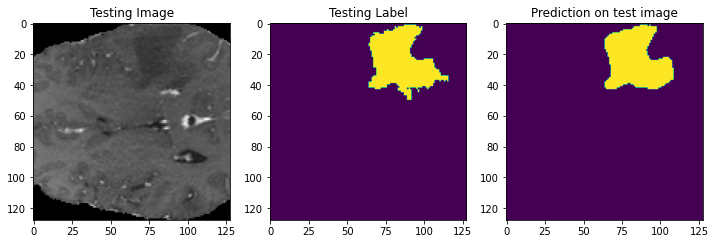

In [ ]:
# Calling the prediction Function...
test_img = "/content/drive/MyDrive/input2/val/images/image_"
test_feature = "/content/drive/MyDrive/Meijering_input2/Meijering_input2/val/images/image_"
test_mask = "/content/drive/MyDrive/input2/val/masks/mask_"

Prediction(15, test_img, test_feature, test_mask)

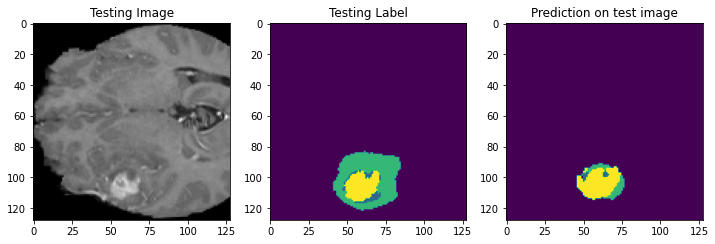

In [ ]:
Prediction(132, test_img, test_feature, test_mask)

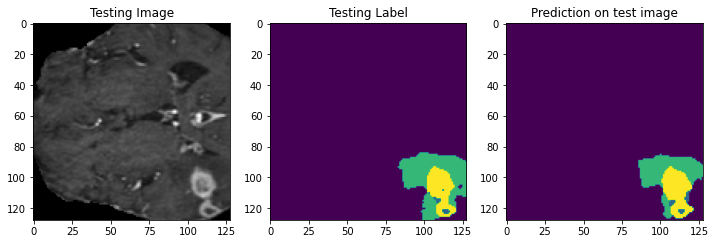

In [ ]:
Prediction(126, test_img, test_feature, test_mask)

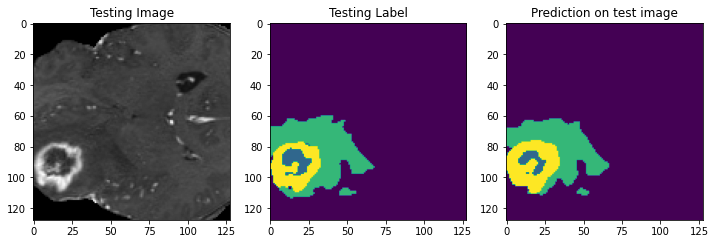

In [ ]:
Prediction(120, test_img, test_feature, test_mask)

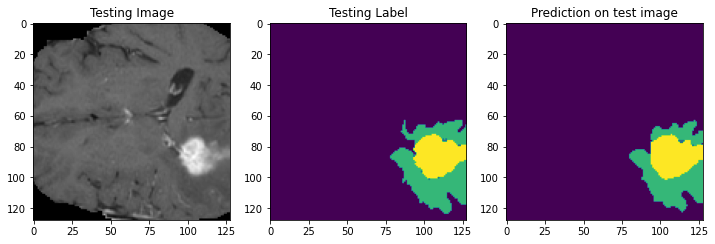

In [ ]:
Prediction(200, test_img, test_feature, test_mask)

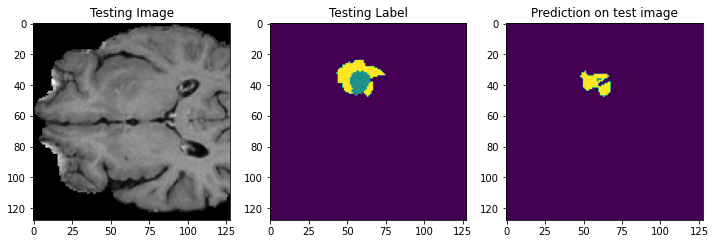

In [ ]:
Prediction(303, test_img, test_feature, test_mask)

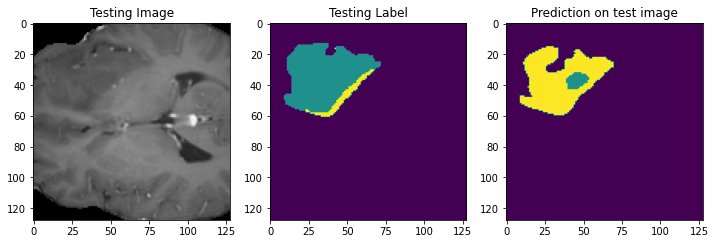

In [ ]:
Prediction(323, test_img, test_feature, test_mask)

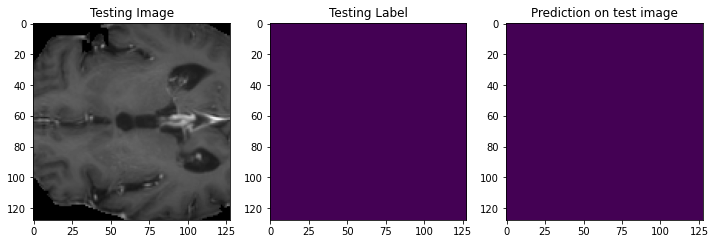

In [ ]:
Prediction(345, test_img, test_feature, test_mask)

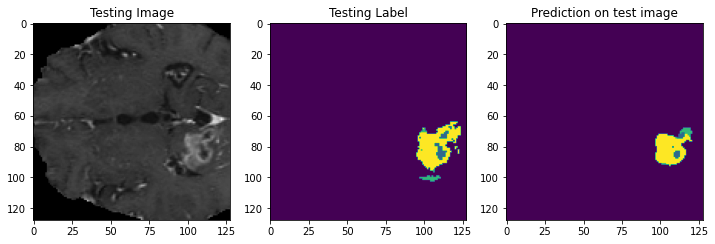

In [ ]:
Prediction(41, test_img, test_feature, test_mask)

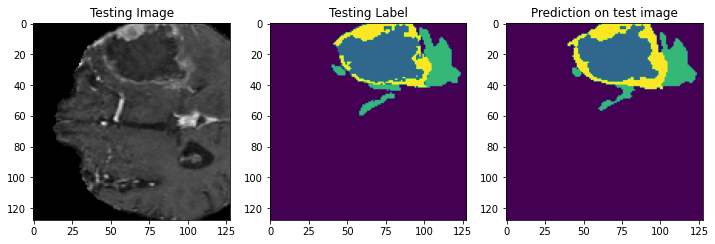

In [ ]:
Prediction(99, test_img, test_feature, test_mask)

## 3. With increased Sharpness (x2.5)

### Training First 20 Epochs

In [ ]:
history=new_model.fit(
        train_img_datagen,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        verbose=1,
        validation_data=val_img_datagen,
        validation_steps=val_steps_per_epoch,
        )

new_model.save('/content/drive/MyDrive/MODELS/5_epochs_hybrid_model(3).hdf5')

Epoch 1/5
129/129 [==============================] - 1054s 8s/step - loss: 0.9492 - accuracy: 0.9280 - iou_score: 0.2203 - val_loss: 0.9387 - val_accuracy: 0.9167 - val_iou_score: 0.2300
Epoch 2/5
129/129 [==============================] - 808s 6s/step - loss: 0.9269 - accuracy: 0.9451 - iou_score: 0.2849 - val_loss: 0.9276 - val_accuracy: 0.9121 - val_iou_score: 0.2931
Epoch 3/5
129/129 [==============================] - 723s 6s/step - loss: 0.9194 - accuracy: 0.9425 - iou_score: 0.3081 - val_loss: 0.9167 - val_accuracy: 0.9407 - val_iou_score: 0.3218
Epoch 4/5
129/129 [==============================] - 720s 6s/step - loss: 0.9100 - accuracy: 0.9435 - iou_score: 0.3508 - val_loss: 0.9075 - val_accuracy: 0.9499 - val_iou_score: 0.3450
Epoch 5/5
129/129 [==============================] - 707s 6s/step - loss: 0.9046 - accuracy: 0.9439 - iou_score: 0.3663 - val_loss: 0.8994 - val_accuracy: 0.9535 - val_iou_score: 0.3737


In [ ]:
for x in range(5,20,5):
    src = '/content/drive/MyDrive/MODELS/'+str(x)+'_epochs_hybrid_model(3).hdf5'
    dst = '/content/drive/MyDrive/MODELS/'+str(x+5)+'_epochs_hybrid_model(3).hdf5'

    continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 718s 6s/step - loss: 0.8979 - accuracy: 0.9491 - iou_score: 0.3854 - val_loss: 0.8926 - val_accuracy: 0.9546 - val_iou_score: 0.3957
Epoch 2/5
129/129 [==============================] - 703s 5s/step - loss: 0.8950 - accuracy: 0.9471 - iou_score: 0.3923 - val_loss: 0.8912 - val_accuracy: 0.9578 - val_iou_score: 0.3971
Epoch 3/5
129/129 [==============================] - 686s 5s/step - loss: 0.8892 - accuracy: 0.9541 - iou_score: 0.4079 - val_loss: 0.8880 - val_accuracy: 0.9540 - val_iou_score: 0.4103
Epoch 4/5
129/129 [==============================] - 694s 5s/step - loss: 0.8864 - accuracy: 0.9541 - iou_score: 0.4159 - val_loss: 0.8905 - val_accuracy: 0.9540 - val_iou_score: 0.4012
Epoch 5/5
129/129 [==============================] - 675s 5s/step - loss: 0.8855 - accuracy: 0.9554 - iou_score: 0.4196 - val_loss: 0.8845 - val_accuracy: 0.9614 - val_iou_score: 0.4202
Epoch 1/5
129/129 [==============================] - 676s 5s/step - lo

### 20-40 Epochs

In [ ]:
for x in range(20,40,5):
    src = '/content/drive/MyDrive/MODELS/'+str(x)+'_epochs_hybrid_model(3).hdf5'
    dst = '/content/drive/MyDrive/MODELS/'+str(x+5)+'_epochs_hybrid_model(3).hdf5'

    continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 675s 5s/step - loss: 0.8301 - accuracy: 0.9768 - iou_score: 0.6050 - val_loss: 0.8396 - val_accuracy: 0.9760 - val_iou_score: 0.5744
Epoch 2/5
129/129 [==============================] - 676s 5s/step - loss: 0.8306 - accuracy: 0.9763 - iou_score: 0.6035 - val_loss: 0.8398 - val_accuracy: 0.9760 - val_iou_score: 0.5754
Epoch 3/5
129/129 [==============================] - 682s 5s/step - loss: 0.8270 - accuracy: 0.9772 - iou_score: 0.6168 - val_loss: 0.8346 - val_accuracy: 0.9750 - val_iou_score: 0.5954
Epoch 4/5
129/129 [==============================] - 686s 5s/step - loss: 0.8245 - accuracy: 0.9778 - iou_score: 0.6257 - val_loss: 0.8327 - val_accuracy: 0.9740 - val_iou_score: 0.6039
Epoch 5/5
129/129 [==============================] - 670s 5s/step - loss: 0.8207 - accuracy: 0.9791 - iou_score: 0.6397 - val_loss: 0.8299 - val_accuracy: 0.9750 - val_iou_score: 0.6136
Epoch 1/5
129/129 [==============================] - 677s 5s/step - lo

### 40-60 Epochs

In [ ]:
for x in range(40,60,5):
    src = '/content/drive/MyDrive/MODELS/'+str(x)+'_epochs_hybrid_model(3).hdf5'
    dst = '/content/drive/MyDrive/MODELS/'+str(x+5)+'_epochs_hybrid_model(3).hdf5'

    continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 664s 5s/step - loss: 0.7983 - accuracy: 0.9855 - iou_score: 0.7313 - val_loss: 0.8259 - val_accuracy: 0.9773 - val_iou_score: 0.6352
Epoch 2/5
129/129 [==============================] - 665s 5s/step - loss: 0.7974 - accuracy: 0.9858 - iou_score: 0.7359 - val_loss: 0.8240 - val_accuracy: 0.9787 - val_iou_score: 0.6414
Epoch 3/5
129/129 [==============================] - 654s 5s/step - loss: 0.7987 - accuracy: 0.9855 - iou_score: 0.7315 - val_loss: 0.8269 - val_accuracy: 0.9773 - val_iou_score: 0.6349
Epoch 4/5
129/129 [==============================] - 664s 5s/step - loss: 0.7999 - accuracy: 0.9850 - iou_score: 0.7272 - val_loss: 0.8268 - val_accuracy: 0.9784 - val_iou_score: 0.6293
Epoch 5/5
129/129 [==============================] - 665s 5s/step - loss: 0.7973 - accuracy: 0.9856 - iou_score: 0.7362 - val_loss: 0.8244 - val_accuracy: 0.9781 - val_iou_score: 0.6378
Epoch 1/5
129/129 [==============================] - 658s 5s/step - lo

### 60-80 Epochs

In [ ]:
for x in range(60,80,5):
    src = '/content/drive/MyDrive/MODELS/'+str(x)+'_epochs_hybrid_model(3).hdf5'
    dst = '/content/drive/MyDrive/MODELS/'+str(x+5)+'_epochs_hybrid_model(3).hdf5'

    continueTraining(src, dst)

Epoch 1/5
129/129 [==============================] - 725s 6s/step - loss: 0.7887 - accuracy: 0.9886 - iou_score: 0.7750 - val_loss: 0.8180 - val_accuracy: 0.9796 - val_iou_score: 0.6623
Epoch 2/5
129/129 [==============================] - 710s 6s/step - loss: 0.7876 - accuracy: 0.9890 - iou_score: 0.7801 - val_loss: 0.8178 - val_accuracy: 0.9800 - val_iou_score: 0.6621
Epoch 3/5
129/129 [==============================] - 688s 5s/step - loss: 0.7871 - accuracy: 0.9891 - iou_score: 0.7826 - val_loss: 0.8160 - val_accuracy: 0.9811 - val_iou_score: 0.6698
Epoch 4/5
129/129 [==============================] - 714s 6s/step - loss: 0.7869 - accuracy: 0.9892 - iou_score: 0.7839 - val_loss: 0.8180 - val_accuracy: 0.9807 - val_iou_score: 0.6634
Epoch 5/5
129/129 [==============================] - 704s 5s/step - loss: 0.7876 - accuracy: 0.9889 - iou_score: 0.7805 - val_loss: 0.8170 - val_accuracy: 0.9808 - val_iou_score: 0.6674
Epoch 1/5
129/129 [==============================] - 717s 6s/step - lo

### Making some Predictions

In [ ]:
my_model = load_model('/content/drive/MyDrive/MODELS/80_epochs_hybrid_model(3).hdf5', compile=False)

# Verify IoU on a batch of images from the test dataset
from tensorflow.keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
# test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

test_img_datagen = imageLoader2(train_img_dir, train_img_list, train_feature_dir, train_feature_list, 
                                    train_mask_dir, train_mask_list, train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7802291


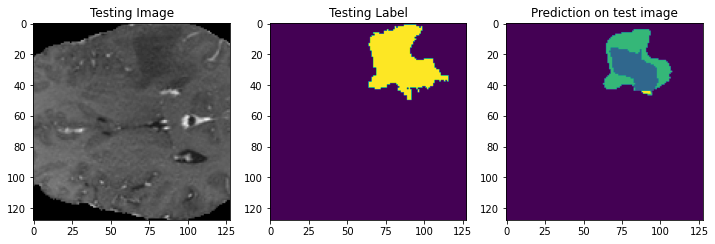

In [ ]:
# Calling the prediction Function...
test_img = "/content/drive/MyDrive/input2/val/images/image_"
test_feature = "/content/drive/MyDrive/Sharp_input2/Sharp_input2/val/images/image_"
test_mask = "/content/drive/MyDrive/input2/val/masks/mask_"

Prediction(15, test_img, test_feature, test_mask)

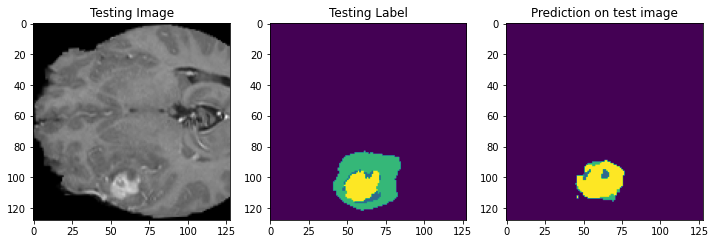

In [ ]:
Prediction(132, test_img, test_feature, test_mask)

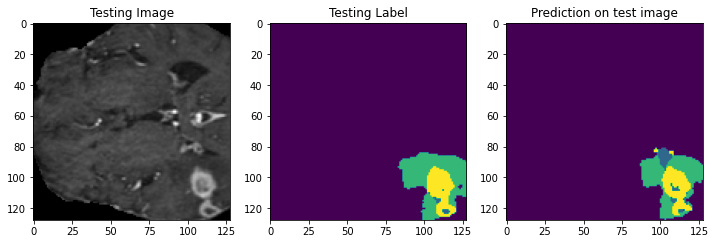

In [ ]:
Prediction(126, test_img, test_feature, test_mask)

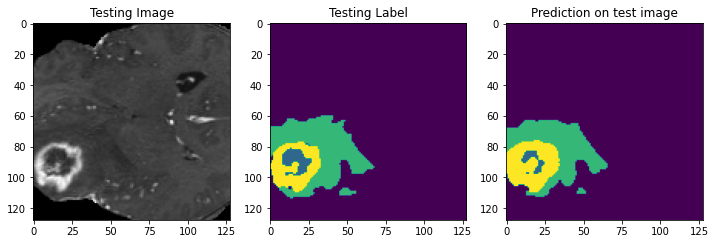

In [ ]:
Prediction(120, test_img, test_feature, test_mask)

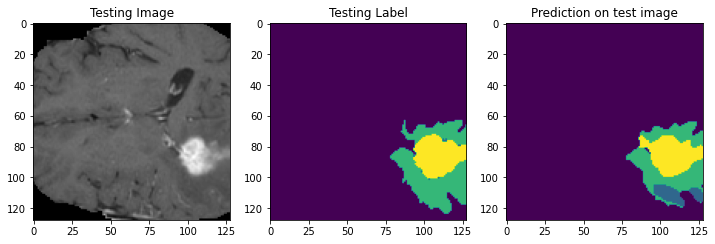

In [ ]:
Prediction(200, test_img, test_feature, test_mask)

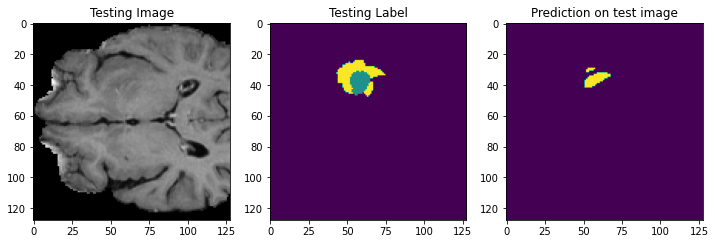

In [ ]:
Prediction(303, test_img, test_feature, test_mask)

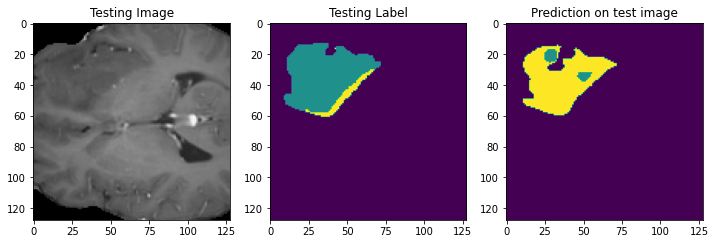

In [ ]:
Prediction(323, test_img, test_feature, test_mask)

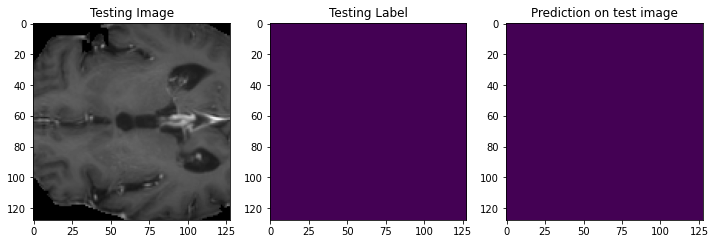

In [ ]:
Prediction(345, test_img, test_feature, test_mask)

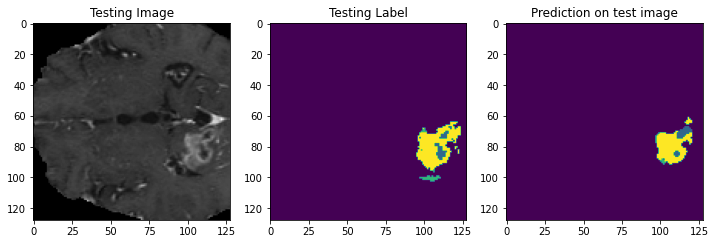

In [ ]:
Prediction(41, test_img, test_feature, test_mask)

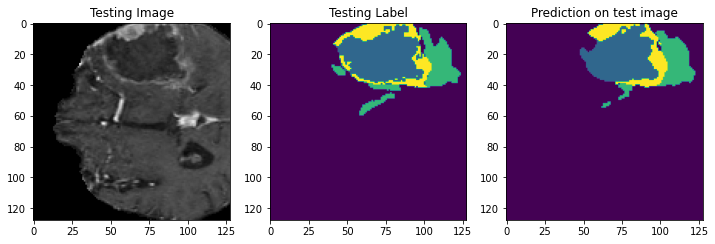

In [ ]:
Prediction(99, test_img, test_feature, test_mask)

# Model Summaries

### 1. Simple U-Net

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

### 2. New U-Net Model

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        